
# Problem Statement

Cinema attendance forecasting is a crucial task for theatre operators, ticketing platforms, and the entertainment industry. Accurate predictions enable:

* **Optimized resource allocation:** staffing, concession planning, screen assignment, etc.
* **Better revenue planning:** understanding demand for blockbuster releases, weekends, and holidays.
* **Improved user experience:** balancing seat availability and show timings with audience demand.

In this competition, you are provided with **time-series data** from two different sources:

* **BookNow** – an online booking platform where users reserve tickets in advance.
* **CinePOS** – a theatre point-of-sale (POS) system capturing on-site ticket sales.

The task is to **predict the daily theatre audience counts (`audience_count`)** for multiple BookNow theatres. Predictions must be submitted for each unique combination of:

* `book_theater_id`
* `show_date`

with the required format:

```
ID = book_theater_id + show_date
audience_count = predicted value
```

---

### Objective

To build a **robust forecasting model** to accurately predict future **daily audience counts** across BookNow theatres.

# Loading the Dataset

In [1]:
# ================================
# Importing Basic Libraries
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For nicer plots
sns.set(style="whitegrid")

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv


In [3]:
# ================================
# Load Data 
# ================================
movie_theater_id_relation  = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv")
date_info          = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv")
sample_submission  = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv")
booknow_theaters   = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv")
cinePOS_booking    = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv")
cinePOS_theaters   = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv")
booknow_visits     = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv")
booknow_booking    = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv")

In [4]:
sso=sample_submission.copy()

# ---------------- Step 1: Start from sample submission ----------------
sso[['book_theater_id','show_date']] = sso['ID'].str.rsplit('_', n=1, expand=True)
sso['show_date'] = pd.to_datetime(sso['show_date'])

In [5]:
sso.info()
print('---------------------')
sso.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38062 entries, 0 to 38061
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               38062 non-null  object        
 1   audience_count   38062 non-null  int64         
 2   book_theater_id  38062 non-null  object        
 3   show_date        38062 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.2+ MB
---------------------


,ID,audience_count,book_theater_id,show_date
0,book_00001_2024-03-01,0,book_00001,2024-03-01
1,book_00001_2024-03-02,0,book_00001,2024-03-02
2,book_00001_2024-03-03,0,book_00001,2024-03-03
3,book_00001_2024-03-04,0,book_00001,2024-03-04
4,book_00001_2024-03-06,0,book_00001,2024-03-06


In [6]:
# Check minimum and maximum show_date
min_date = sso['show_date'].min()
max_date = sso['show_date'].max()

# Count number of unique book_theater_id
unique_theaters = sso['book_theater_id'].nunique()



print(f"Minimum show date: {min_date}")
print(f"Maximum show date: {max_date}")
print(f"Number of unique book_theater_id: {unique_theaters}")

Minimum show date: 2024-03-01 00:00:00
Maximum show date: 2024-04-22 00:00:00
Number of unique book_theater_id: 827


# Individual Cleaning + EDA¶

In [7]:
#reusable function
def explore_dataframe(df):
    """
    Prints detailed information about a DataFrame:
    - Shape (rows, columns)
    - Info (data types, non-null counts)
    - Unique values count per column
    - Missing values count per column
    - Number of fully duplicated rows
    """
    print("Shape:", df.shape)
    print("\n DataFrame Info:")
    print("-" * 40)
    df.info()

    print("\n Unique Values per Column:")
    print("-" * 40)
    for col in df.columns:
        print(f"{col}: {df[col].nunique()} unique values")

    print("\n Missing Values per Column:")
    print("-" * 40)
    print(df.isnull().sum())

    print("\n Number of Fully Duplicated Rows:", df.duplicated().sum())

First, we will explore the booknow_visits dataset because it contains the target variable "audience_count" — that we are trying to predict

In [8]:
booknow_visits.head()

,book_theater_id,show_date,audience_count
0,book_00001,2023-01-13,50
1,book_00001,2023-01-14,64
2,book_00001,2023-01-15,58
3,book_00001,2023-01-16,44
4,book_00001,2023-01-18,12


In [9]:
explore_dataframe(booknow_visits)

Shape: (214046, 3)

 DataFrame Info:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   book_theater_id  214046 non-null  object
 1   show_date        214046 non-null  object
 2   audience_count   214046 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.9+ MB

 Unique Values per Column:
----------------------------------------
book_theater_id: 826 unique values
show_date: 424 unique values
audience_count: 191 unique values

 Missing Values per Column:
----------------------------------------
book_theater_id    0
show_date          0
audience_count     0
dtype: int64

 Number of Fully Duplicated Rows: 10


In [10]:
# Convert show_date to datetime
booknow_visits['show_date'] = pd.to_datetime(booknow_visits['show_date'], errors='coerce')

print("--------------------------------------")

print(booknow_visits.info())

--------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   book_theater_id  214046 non-null  object        
 1   show_date        214046 non-null  datetime64[ns]
 2   audience_count   214046 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 4.9+ MB
None


In [11]:
booknow_visits = booknow_visits.drop_duplicates()

#recheck
print(booknow_visits.duplicated().sum())

0


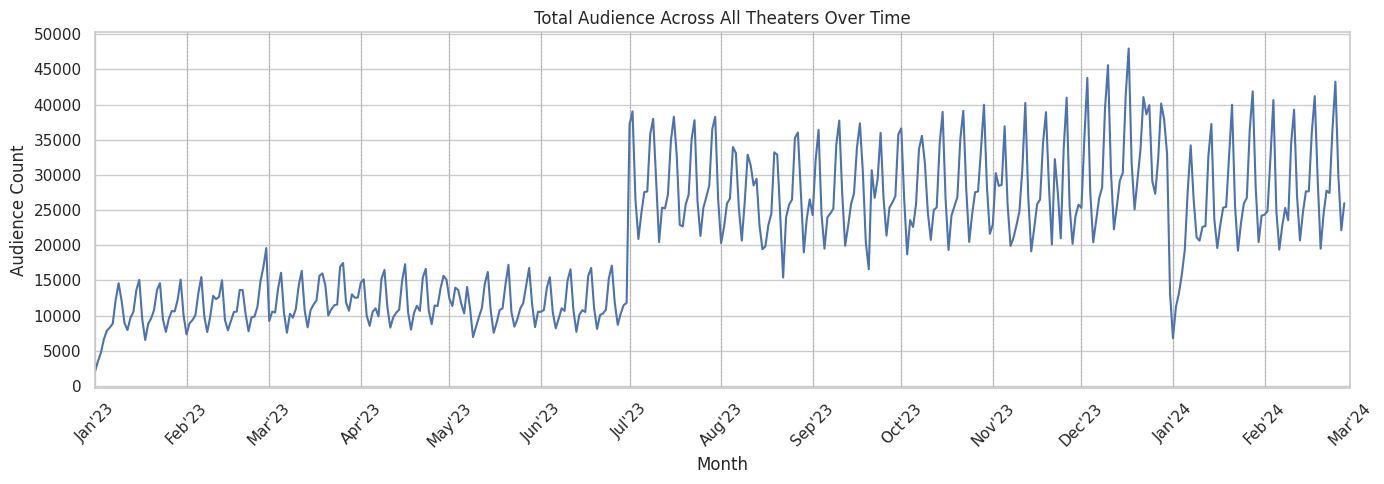

In [12]:
# Daily total audience
daily_total = booknow_visits.groupby('show_date')['audience_count'].sum()

# Plot
plt.figure(figsize=(14,5))
daily_total.plot(title="Total Audience Across All Theaters Over Time")

# Format x-axis month-wise
start = pd.to_datetime("2023-01-01")
end = pd.to_datetime("2024-03-31")   # extend to March'24
month_starts = pd.date_range(start=start, end=end, freq='MS')

plt.xticks(
    month_starts, 
    [d.strftime("%b'%y") for d in month_starts], 
    rotation=45
)

# Set y-axis ticks at 0, 5000, 10000, 15000, ...
max_y = daily_total.max()
plt.yticks(np.arange(0, max_y + 5000, 5000))

# Add vertical gridlines for each month
for month in month_starts:
    plt.axvline(x=month, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.xlabel("Month")
plt.ylabel("Audience Count")
plt.tight_layout()
plt.show()

### Total Audience Across All Theaters Over Time

The **"Total Audience Across All Theaters Over Time"** chart visualizes the daily audience count from **January 2023 to February 2024**. The trend shows **two clearly separated phases of audience engagement**, marked by a **significant upward jump starting July 2023**.

---

### **1. Initial Period (January – June 2023)**

During this phase:

* Audience levels were **low and stable**, ranging between **5,000 and 20,000**.
* A clear **weekly seasonal pattern** is present, with predictable **peaks on weekends** and **troughs on weekdays**.
* The overall trend remains **flat**, indicating steady but modest activity.

---

### **2. Post-Jump Period (July 2023 – March 2024)**

Starting July 2023, the chart shows a **sharp and sustained rise** in audience count:

* Daily audience jumps to a much higher band of **15,000 to 50,000**.
* The **weekly cycle continues**, but with **much larger peaks and troughs**, reflecting scalable growth.
* The underlying behavior (weekend vs. weekday pattern) stays the same, but the **magnitude increases dramatically**.

This shift suggests a **structural change in the business**, such as:

* Onboarding new theatres
* Increased screen capacity
* Major movie releases
* Platform expansion or marketing pushes

---

### ⚠️ **3. Notable Anomalies**

A sharp **dip in January 2024** stands out as a significant outlier. Potential explanations include:

* Holiday closures (e.g., Christmas/New Year downtime)
* Data recording issues
* Temporary shutdowns or disruptions

---

### **Key Insight**

The **abrupt jump in July 2023** is the most important observation. It represents a **transition to a new operational scale**, likely driven by business-level changes rather than organic growth.
Yet, the consistent weekly seasonality across both periods indicates that **audience behaviour remains highly predictable**.

---

### What caused this sudden rise?

Let’s dig deeper and investigate the root of this jump!


In [13]:
unique_theater_count = booknow_visits['book_theater_id'].nunique()
unique_theater_count

#This gives the number of unique theaters.

826

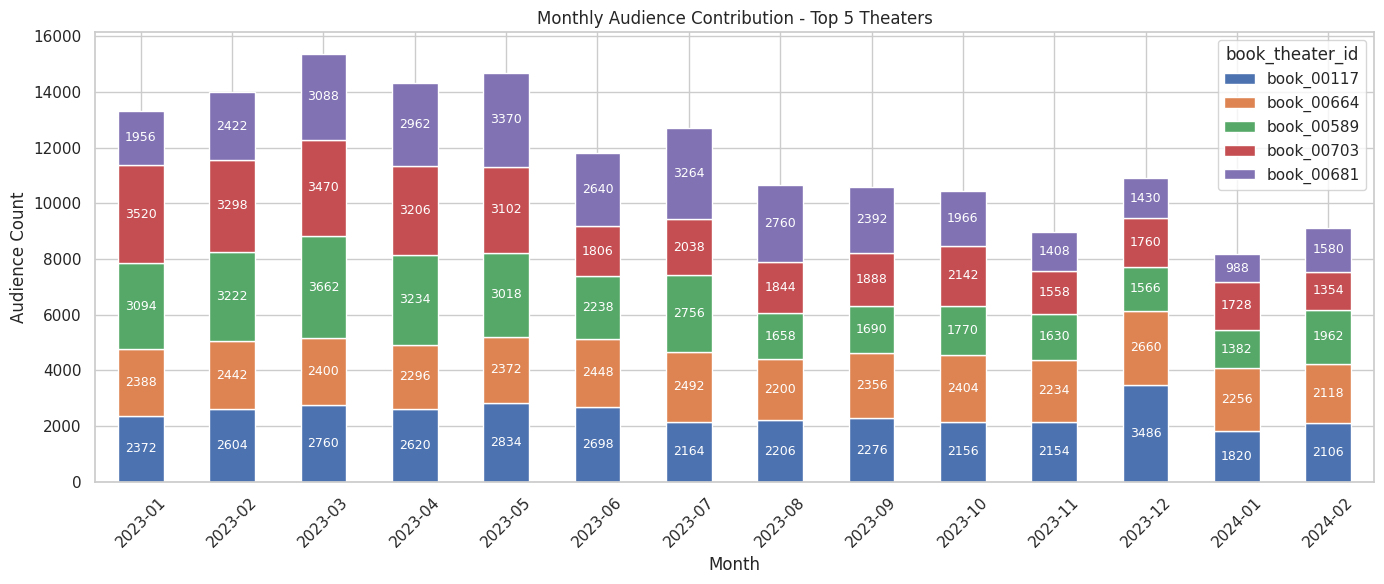

In [14]:
booknow_visits_ed=booknow_visits.copy()

# Extract month period
booknow_visits_ed['month'] = booknow_visits_ed['show_date'].dt.to_period('M')


# Group by month and theater, sum audience (Sums up the audience counts for each theater per month.)
#Missing values (no audience for a theater in a month) are filled with 0.
monthly_per_theater = booknow_visits_ed.groupby(['month', 'book_theater_id'])['audience_count'].sum().unstack(fill_value=0)

# Total audience per theater over entire period
total_audience_per_theater = monthly_per_theater.sum()

# Top 5 theaters
#the top 5 theatres are chosen based on their total audience count across the entire period
top_5_theaters = total_audience_per_theater.nlargest(5).index


ax = monthly_per_theater[top_5_theaters].plot(
    kind='bar', stacked=True, figsize=(14,6)
)

plt.title("Monthly Audience Contribution - Top 5 Theaters")
plt.xlabel("Month")
plt.ylabel("Audience Count")
plt.xticks(rotation=45)
# Annotate each segment
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if height > 0:
        x, y = p.get_xy()  # bottom-left corner of the bar
        ax.text(x + width/2, y + height/2, f'{int(height)}', 
                ha='center', va='center', fontsize=9, color='white')

plt.tight_layout()
plt.show()

### Observations from the Chart

The **Total Audience Across All Theaters Over Time** chart highlights a **sharp increase** in total audience starting around **July 2023**. This sudden jump suggests a **major business shift**—possibly new theatre openings, platform expansion, or a wave of blockbuster releases.
Despite this jump, the **weekly pattern remains consistent**, indicating that audience behaviour continues to follow predictable weekday–weekend cycles.

---

### Insights from Top 5 Theaters' Monthly Contributions

To further understand this shift, we examine the **monthly audience contributions from the top 5 theaters**:

* Each bar represents a month, and each color segment corresponds to **one of the top 5 theaters** by total audience.
* **Before July**, these theaters account for a major share of the total audience, matching the stable audience levels seen in the line chart.
* **After July**, even though total audience increases dramatically, the **relative contribution of the top 5 theaters decreases**.
* This indicates that the **growth is coming from other theaters**, not just the previously dominant ones.
* Months like **August to November** show noticeably lower combined audience for the top 5 theaters, suggesting that **new or smaller theaters are capturing more audience share**.
* Occasional rebounds—such as **December**—hint at seasonality or special events still influencing attendance.

---

### Possible Interpretation

* The **post-July spike** likely reflects **the addition of new theaters or operational expansion**, rather than increased performance of existing top theaters.
* The **declining share of the top 5 theaters** indicates that the overall audience is becoming **more evenly distributed** across the theater network.
* While weekly patterns remain stable, the data strongly suggests a **shift in scale and distribution** rather than a mere uplift in previous top performers.

In [15]:
booknow_visits_ed['period'] = np.where(booknow_visits_ed['show_date'] < '2023-07-01', 'pre_july', 'post_july')
period_audience = booknow_visits_ed.groupby(['book_theater_id','period'])['audience_count'].sum().unstack(fill_value=0)
period_audience['increase'] = period_audience['post_july'] - period_audience['pre_july']
period_audience.sort_values('increase', ascending=False).head(10)

period,post_july,pre_july,increase
book_theater_id,,,
book_00169,25126,0,25126
book_00825,19948,0,19948
book_00177,19770,0,19770
book_00490,19110,0,19110
book_00458,18854,0,18854
book_00734,18590,0,18590
book_00361,18546,0,18546
book_00602,18518,0,18518
book_00057,18470,0,18470


In [16]:
# Label each row as pre_july or post_july
booknow_visits_ed['period'] = np.where(
    booknow_visits_ed['show_date'] < '2023-07-01',
    'pre_july', 'post_july'
)

# Aggregate audience counts by theater & period
period_audience = (
    booknow_visits_ed
    .groupby(['book_theater_id','period'])['audience_count']
    .sum()
    .unstack(fill_value=0)
)

period_audience['pct_change'] = np.where(
    period_audience['pre_july'] == 0,
    np.where(period_audience['post_july'] == 0, 0, np.nan),  # temporarily NaN for new theaters
    (period_audience['post_july'] - period_audience['pre_july']) /
    period_audience['pre_july'] * 100
)

# Replace NaN with "New"
period_audience['pct_change'] = period_audience['pct_change'].replace(np.nan, 'New')

# Sort with custom rule: put "New" on top
period_audience_sorted = period_audience.sort_values(
    by='pct_change',
    key=lambda col: col.replace('New', np.inf),  # treat 'New' as inf when sorting
    ascending=False
)

period_audience_sorted.head(10)

/tmp/ipykernel_13/838156202.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  key=lambda col: col.replace('New', np.inf),  # treat 'New' as inf when sorting


period,post_july,pre_july,pct_change
book_theater_id,,,
book_00416,2434,0,New
book_00491,7466,0,New
book_00483,7982,0,New
book_00484,5604,0,New
book_00485,12116,0,New
book_00486,12018,0,New
book_00488,4288,0,New
book_00489,3846,0,New
book_00490,19110,0,New


In [17]:
# Extract new theatre IDs from your existing logic
new_theatres = period_audience[period_audience['pct_change'] == 'New'].index

print(new_theatres.value_counts().sum())

booknow_visits['new_or_old'] = np.where(
    booknow_visits['book_theater_id'].isin(new_theatres),
    'new',
    'old'
)

print(booknow_visits['new_or_old'].value_counts())

510
new_or_old
old    112264
new    101772
Name: count, dtype: int64


In [18]:
# Count total theaters
total_theaters = len(period_audience)

# Count how many are new (pre_july = 0 and post_july > 0)
num_new_theaters = ((period_audience['pre_july'] == 0) & 
                    (period_audience['post_july'] > 0)).sum()

# Compute percentage
pct_new_theaters = (num_new_theaters / total_theaters) * 100

print(f"Total theaters: {total_theaters}")
print(f"New theaters: {num_new_theaters}")
print(f"Percentage of new theaters: {pct_new_theaters:.2f}%")

Total theaters: 826
New theaters: 510
Percentage of new theaters: 61.74%


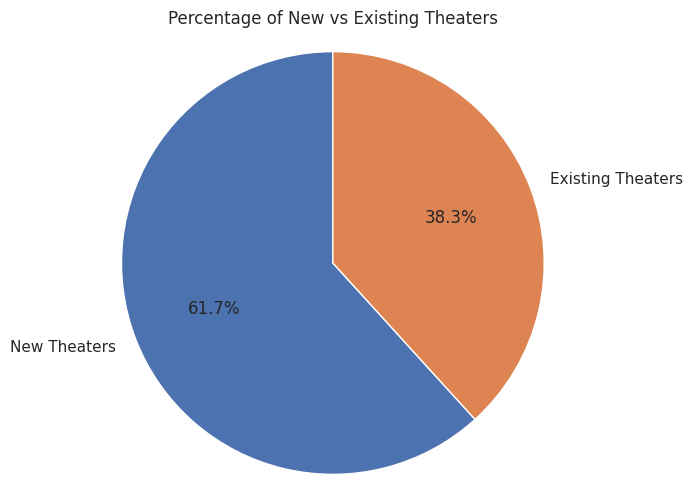

In [19]:

# existing values
total_theaters = len(period_audience)
num_new_theaters = ((period_audience['pre_july'] == 0) & 
                    (period_audience['post_july'] > 0)).sum()
num_existing_theaters = total_theaters - num_new_theaters

# Pie chart
labels = ['New Theaters', 'Existing Theaters']
sizes = [num_new_theaters, num_existing_theaters]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of New vs Existing Theaters')
plt.axis('equal')  # keeps the pie chart circular
plt.show()

In [20]:
# then aggregate by theater and date
booknow_visits = (
    booknow_visits
    .groupby(['book_theater_id', 'show_date'], as_index=False)
    .agg({'audience_count': 'sum'})  # sum daily counts
)
booknow_visits

,book_theater_id,show_date,audience_count
0,book_00001,2023-01-13,50
1,book_00001,2023-01-14,64
2,book_00001,2023-01-15,58
3,book_00001,2023-01-16,44
4,book_00001,2023-01-18,12
...,...,...,...
213866,book_00829,2024-02-23,16
213867,book_00829,2024-02-24,8
213868,book_00829,2024-02-25,16
213869,book_00829,2024-02-27,16


In [21]:
explore_dataframe(booknow_visits)

Shape: (213871, 3)

 DataFrame Info:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213871 entries, 0 to 213870
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   book_theater_id  213871 non-null  object        
 1   show_date        213871 non-null  datetime64[ns]
 2   audience_count   213871 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 4.9+ MB

 Unique Values per Column:
----------------------------------------
book_theater_id: 826 unique values
show_date: 424 unique values
audience_count: 191 unique values

 Missing Values per Column:
----------------------------------------
book_theater_id    0
show_date          0
audience_count     0
dtype: int64

 Number of Fully Duplicated Rows: 0


In [22]:
print("Earliest show date:", booknow_visits['show_date'].min())
print("Latest show date:", booknow_visits['show_date'].max())

Earliest show date: 2023-01-01 00:00:00
Latest show date: 2024-02-28 00:00:00


Let's explore date_info now.

In [23]:
date_info.head()

,show_date,day_of_week
0,2023-01-01,Sunday
1,2023-01-02,Monday
2,2023-01-03,Tuesday
3,2023-01-04,Wednesday
4,2023-01-05,Thursday


In [24]:
explore_dataframe(date_info)

Shape: (547, 2)

 DataFrame Info:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   show_date    547 non-null    object
 1   day_of_week  547 non-null    object
dtypes: object(2)
memory usage: 8.7+ KB

 Unique Values per Column:
----------------------------------------
show_date: 547 unique values
day_of_week: 7 unique values

 Missing Values per Column:
----------------------------------------
show_date      0
day_of_week    0
dtype: int64

 Number of Fully Duplicated Rows: 0


In [25]:
# Convert show_date to datetime
date_info['show_date'] = pd.to_datetime(date_info['show_date'], errors='coerce')

#recheck
print("--------------------------------------")
print(date_info.info())

--------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   show_date    547 non-null    datetime64[ns]
 1   day_of_week  547 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 8.7+ KB
None


In [26]:
# Check minimum and maximum show_date
min_date = date_info['show_date'].min()
max_date = date_info['show_date'].max()


print(f"Minimum show date: {min_date}")
print(f"Maximum show date: {max_date}")

Minimum show date: 2023-01-01 00:00:00
Maximum show date: 2024-06-30 00:00:00


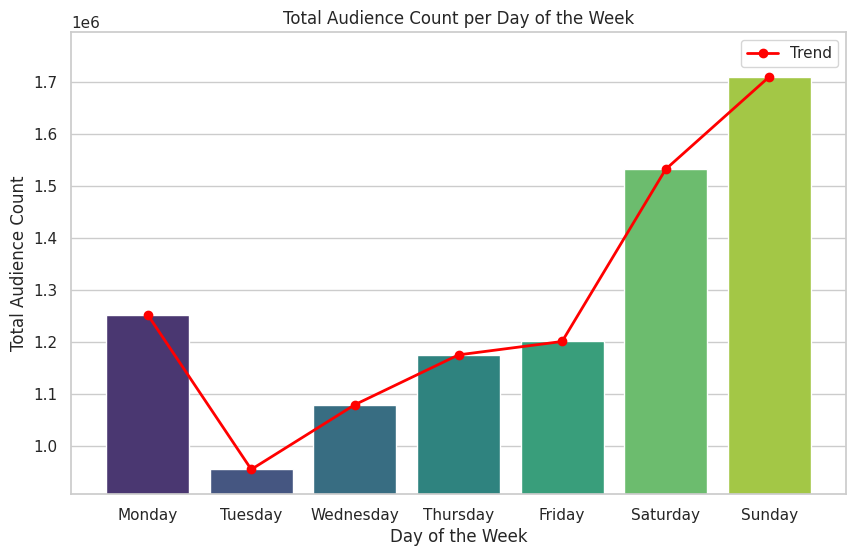

In [27]:
booknow_visits_c=booknow_visits.copy()
date_info_c=date_info.copy()

# Convert show_date to datetime
booknow_visits_c['show_date'] = pd.to_datetime(booknow_visits_c['show_date'])
date_info_c['show_date'] = pd.to_datetime(date_info_c['show_date'])

# Merge the dataframes on show_date
temp_df = pd.merge(booknow_visits_c, date_info_c, on='show_date', how='left')

# Group by day_of_week and sum audience_count
weekly_audience = temp_df.groupby('day_of_week')['audience_count'].sum().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)

# Plotting
plt.figure(figsize=(10, 6))

# Create the bar chart
sns.barplot(x=weekly_audience.index, y=weekly_audience.values, palette='viridis')

# Add the line chart on top
plt.plot(weekly_audience.index, weekly_audience.values, color='red', marker='o', linewidth=2, label='Trend')

# Find the minimum and maximum values for setting the y-axis limits
min_val = weekly_audience.min()
max_val = weekly_audience.max()
# Add a 5% buffer to the min and max values for better visual spacing
y_min_limit = min_val * 0.95
y_max_limit = max_val * 1.05

# Set the y-axis limits
plt.ylim(y_min_limit, y_max_limit)

plt.title('Total Audience Count per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Audience Count')
plt.legend()
plt.show()

### Observations from the Chart

The chart visualizes the **total audience per day of the week** using bars, accompanied by a **red trend line** showing the overall pattern.

### **Weekly Audience Distribution**

* **Lowest audience:** Tuesday (~0.95M)
* **Moderate audience:**

  * Wednesday (~1.08M)
  * Thursday (~1.17M)
* **High audience:**

  * Monday (~1.25M)
  * Friday (~1.20M)
* **Peak audience:**

  * Saturday (~1.53M)
  * Sunday (~1.70M)

The trend line confirms a **steady rise** from midweek toward the weekend.

---

### Interpretation

* Audience behavior is strongly tied to the **day of the week**, influenced by work schedules and weekend leisure habits.
* **Weekends dominate attendance**, with Saturday and Sunday contributing the largest share of weekly viewers.
* **Early-week dips** (Tuesday and Wednesday) reflect lower engagement, likely due to busy schedules and reduced free time.
* **Monday’s relatively high audience**—higher than midweek—may indicate:

  * special promotions,
  * new movie releases, or
  * residual spillover from weekend viewing.
* Overall, audience attendance follows a **predictable weekly cycle**, with **weekend peaks** driving the majority of total views.

---

Let's explore booknow_booking now.

In [28]:
booknow_booking.head()

,book_theater_id,show_datetime,booking_datetime,tickets_booked
0,book_00244,2023-01-01 19:00:00,2023-01-01 16:00:00,1
1,book_00740,2023-01-01 19:00:00,2023-01-01 19:00:00,3
2,book_00740,2023-01-01 19:00:00,2023-01-01 19:00:00,6
3,book_00244,2023-01-01 20:00:00,2023-01-01 16:00:00,2
4,book_00151,2023-01-01 20:00:00,2023-01-01 01:00:00,5


In [29]:
explore_dataframe(booknow_booking)

Shape: (68336, 4)

 DataFrame Info:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68336 entries, 0 to 68335
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   book_theater_id   68336 non-null  object
 1   show_datetime     68336 non-null  object
 2   booking_datetime  68336 non-null  object
 3   tickets_booked    68336 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.1+ MB

 Unique Values per Column:
----------------------------------------
book_theater_id: 301 unique values
show_datetime: 3866 unique values
booking_datetime: 6351 unique values
tickets_booked: 66 unique values

 Missing Values per Column:
----------------------------------------
book_theater_id     0
show_datetime       0
booking_datetime    0
tickets_booked      0
dtype: int64

 Number of Fully Duplicated Rows: 2042


In [30]:
#Convert date columns to datetime
#Right now they’re stored as object, which is not good for time-series analysis.
booknow_booking['show_datetime'] = pd.to_datetime(booknow_booking['show_datetime'], errors='coerce')
booknow_booking['booking_datetime'] = pd.to_datetime(booknow_booking['booking_datetime'], errors='coerce')


print("--------------------------------------")
print(booknow_booking.info())

--------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68336 entries, 0 to 68335
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   book_theater_id   68336 non-null  object        
 1   show_datetime     68336 non-null  datetime64[ns]
 2   booking_datetime  68336 non-null  datetime64[ns]
 3   tickets_booked    68336 non-null  int64         
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 2.1+ MB
None


In [31]:
#Booking after showtime? 

invalid_booknow_bookings = booknow_booking[booknow_booking['booking_datetime'] > booknow_booking['show_datetime']]
print(f"Invalid bookings found: {invalid_booknow_bookings.shape[0]}")

Invalid bookings found: 3


In [32]:
# Keep only valid bookings
booknow_booking = booknow_booking[booknow_booking['booking_datetime'] <= booknow_booking['show_datetime']]

# Reset index (for cleanliness)
booknow_booking = booknow_booking.reset_index(drop=True)

print(booknow_booking.shape)

(68333, 4)


In [33]:
#Negative or zero tickets?
booknow_booking[booknow_booking['tickets_booked'] <= 0]

,book_theater_id,show_datetime,booking_datetime,tickets_booked


In [34]:
# Extract *only* the date from show_datetime to align with booknow_visits
booknow_booking['show_date'] = booknow_booking['show_datetime'].dt.date

# Aggregate by theater and show_date
booknow_booking_daily = (
    booknow_booking
    .groupby(['book_theater_id', 'show_date'], as_index=False)
    .agg(
        total_tickets_booked=('tickets_booked', 'sum'),
        num_booking_events=('booking_datetime', 'count'),
        avg_tickets_booknow_per_booking=('tickets_booked', 'mean'),
    )
)

# Convert show_date to datetime64[ns] for consistent merging later
booknow_booking_daily['show_date'] = pd.to_datetime(booknow_booking_daily['show_date'])

In [35]:
booknow_booking_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21590 entries, 0 to 21589
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   book_theater_id                  21590 non-null  object        
 1   show_date                        21590 non-null  datetime64[ns]
 2   total_tickets_booked             21590 non-null  int64         
 3   num_booking_events               21590 non-null  int64         
 4   avg_tickets_booknow_per_booking  21590 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 843.5+ KB


In [36]:
booknow_booking_daily.head()


,book_theater_id,show_date,total_tickets_booked,num_booking_events,avg_tickets_booknow_per_booking
0,book_00004,2023-02-27,12,1,12.000000
1,book_00013,2023-01-04,2,1,2.000000
2,book_00013,2023-01-08,3,1,3.000000
3,book_00013,2023-01-09,25,12,2.083333
4,book_00013,2023-01-10,5,2,2.500000


In [37]:
df2 = booknow_booking.copy()

# Convert to datetime
df2['show_datetime'] = pd.to_datetime(df2['show_datetime'])
df2['booking_datetime'] = pd.to_datetime(df2['booking_datetime'])

# Extract features
df2['show_date'] = df2['show_datetime'].dt.date
df2['booking_date'] = df2['booking_datetime'].dt.date
df2['booking_hour'] = df2['booking_datetime'].dt.hour
df2['day_of_week'] = df2['booking_datetime'].dt.day_name()

# Lead time in hours
df2['lead_time_hours'] = (df2['show_datetime'] - df2['booking_datetime']).dt.total_seconds() / 3600


df2['lead_time_hours'].describe()

count    68333.000000
mean       217.910380
std        699.342194
min          0.000000
25%          5.000000
50%         50.000000
75%        189.000000
max       9411.000000
Name: lead_time_hours, dtype: float64

The summary statistics show that the lead time distribution is highly skewed. While the median lead time is only 50 hours and 75% of bookings are made within 189 hours (about 8 days), the mean jumps to 218 hours because of a few extremely early bookings. The minimum lead time is 0 hours, indicating last-minute bookings, while the maximum reaches 9,411 hours (around 392 days), creating a very long right tail. The large difference between the median and mean, along with the high standard deviation, confirms that most bookings happen close to the showtime, with only a small number of customers booking far in advance (can be potential error entries too).

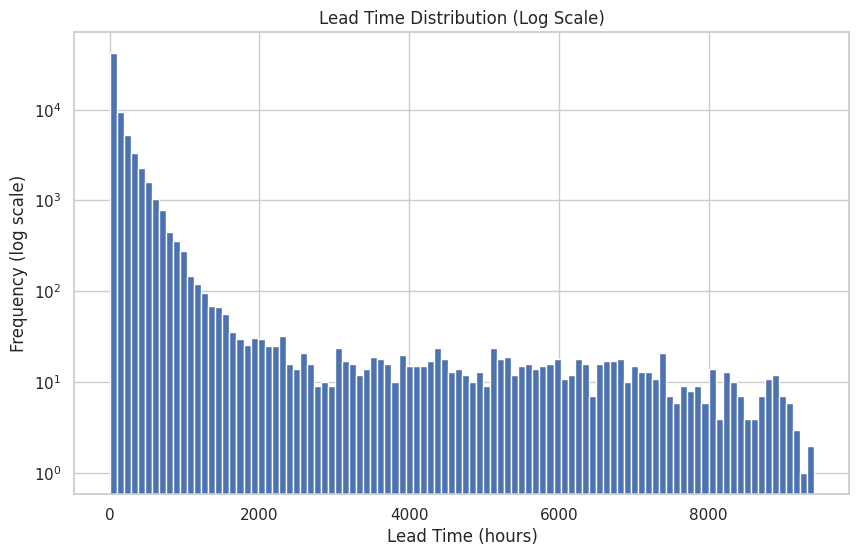

In [38]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,6))
plt.hist(df2['lead_time_hours'], bins=100, log=True)
plt.xlabel("Lead Time (hours)")
plt.ylabel("Frequency (log scale)")
plt.title("Lead Time Distribution (Log Scale)")
plt.show()

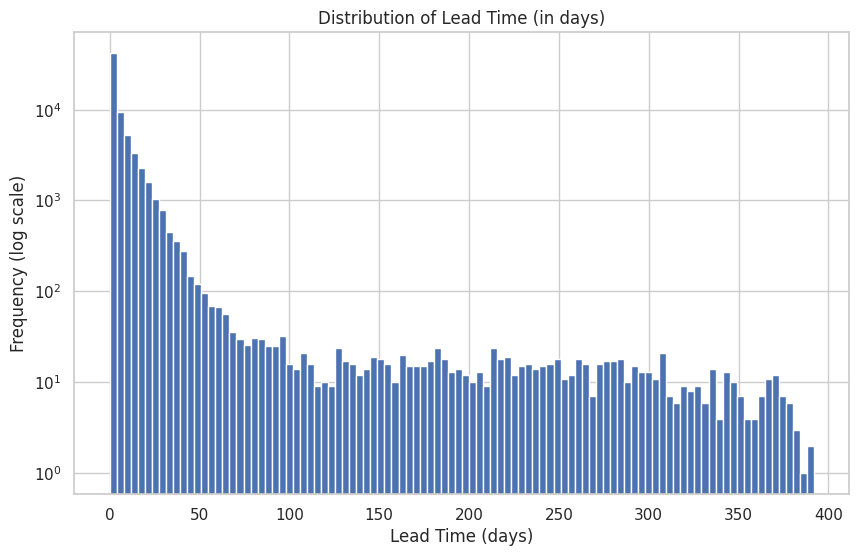

In [39]:
df2['lead_time_days'] = df2['lead_time_hours'] / 24


plt.figure(figsize=(10,6))
plt.hist(df2['lead_time_days'], bins=100, log=True)
plt.xlabel("Lead Time (days)")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Lead Time (in days)")
plt.show()

Using a log scale on the y-axis helps us visualize the lead time distribution better because the data is highly skewed. 

Most bookings happen close to the showtime, while a small number occur very early, creating a long tail.

On a normal scale, the bars with very high counts dominate the plot and make the rest of the distribution look flat.

The log scale compresses large frequencies and expands smaller ones, allowing us to clearly see patterns across both common and rare lead times in the same histogram.

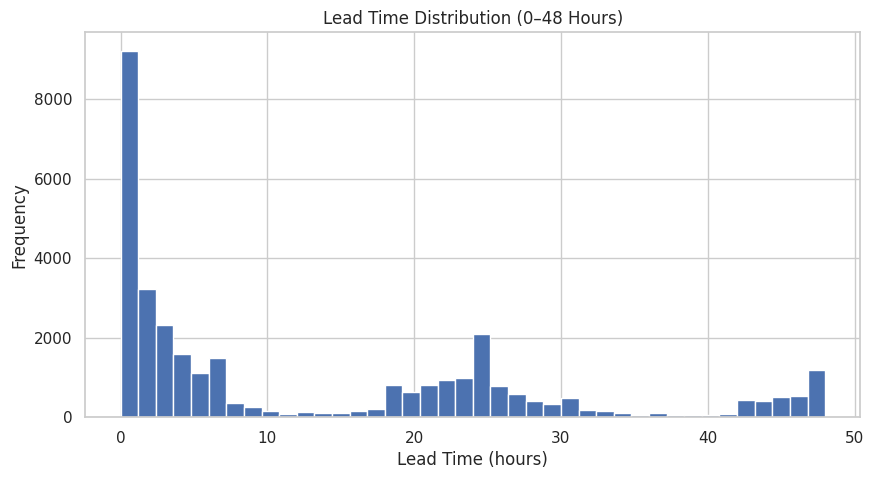

In [40]:
# Limit lead time to 0–48 hours
filtered = df2[df2['lead_time_hours'] <= 48] #Clip at 48 hours

plt.figure(figsize=(10,5))
plt.hist(filtered['lead_time_hours'], bins=40)
plt.title("Lead Time Distribution (0–48 Hours)")
plt.xlabel("Lead Time (hours)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [41]:
booknow_theaters.head()

,book_theater_id,theater_type,theater_area,latitude,longitude
0,book_00093,Drama,Area_001,22.619233,78.113017
1,book_00078,Drama,Area_001,22.619233,78.113017
2,book_00291,Drama,Area_001,22.619233,78.113017
3,book_00258,Drama,Area_001,22.619233,78.113017
4,book_00212,Drama,Area_002,23.004410,79.934515


In [42]:
explore_dataframe(booknow_theaters)

Shape: (829, 5)

 DataFrame Info:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   book_theater_id  314 non-null    object 
 1   theater_type     829 non-null    object 
 2   theater_area     829 non-null    object 
 3   latitude         829 non-null    float64
 4   longitude        829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB

 Unique Values per Column:
----------------------------------------
book_theater_id: 314 unique values
theater_type: 4 unique values
theater_area: 103 unique values
latitude: 108 unique values
longitude: 108 unique values

 Missing Values per Column:
----------------------------------------
book_theater_id    515
theater_type         0
theater_area         0
latitude             0
longitude            0
dtype: int64

 Number of Fully Duplica

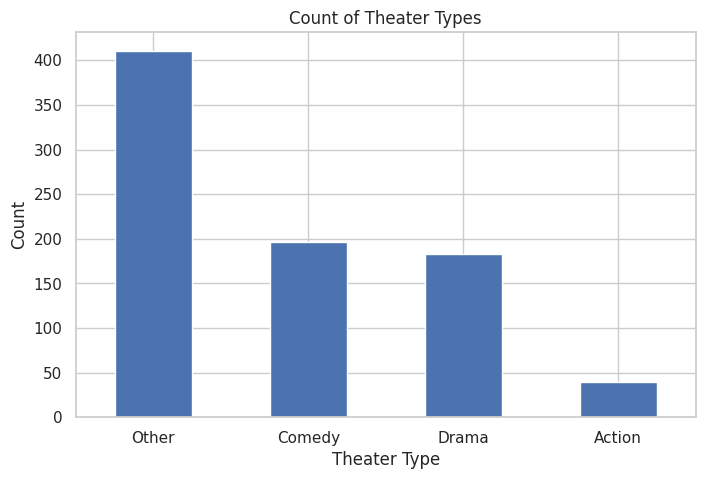

In [43]:
type_counts = booknow_theaters['theater_type'].value_counts()

plt.figure(figsize=(8,5))
type_counts.plot(kind='bar')
plt.title("Count of Theater Types")
plt.xlabel("Theater Type")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

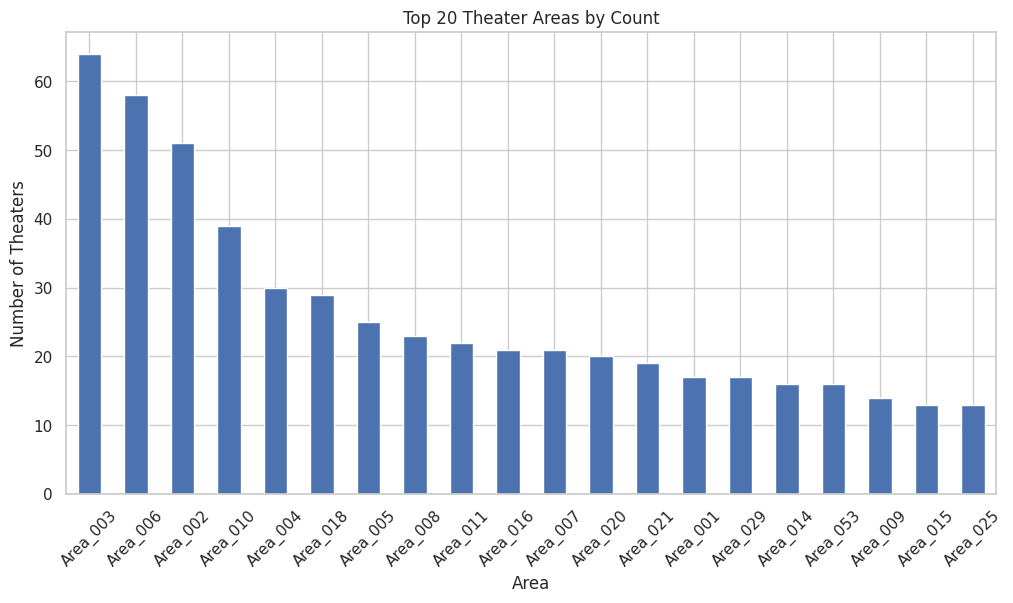

In [44]:
area_counts = booknow_theaters['theater_area'].value_counts().head(20)

plt.figure(figsize=(12,6))
area_counts.plot(kind='bar')
plt.title("Top 20 Theater Areas by Count")
plt.xlabel("Area")
plt.ylabel("Number of Theaters")
plt.xticks(rotation=45)
plt.show()

In [45]:
cinePOS_theaters.head()

,cine_theater_id,theater_type,theater_area,latitude,longitude
0,cinePOS_05466,Other,Area_104,22.619233,78.113017
1,cinePOS_08708,Other,Area_104,22.619233,78.113017
2,cinePOS_00753,Other,Area_104,22.619233,78.113017
3,cinePOS_05776,Other,Area_104,22.619233,78.113017
4,cinePOS_07536,Other,Area_104,23.004410,79.934515


In [46]:
explore_dataframe(cinePOS_theaters)

Shape: (4690, 5)

 DataFrame Info:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cine_theater_id  4690 non-null   object 
 1   theater_type     4690 non-null   object 
 2   theater_area     4690 non-null   object 
 3   latitude         829 non-null    float64
 4   longitude        829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 183.3+ KB

 Unique Values per Column:
----------------------------------------
cine_theater_id: 4690 unique values
theater_type: 3 unique values
theater_area: 119 unique values
latitude: 108 unique values
longitude: 108 unique values

 Missing Values per Column:
----------------------------------------
cine_theater_id       0
theater_type          0
theater_area          0
latitude           3861
longitude          3861
dtype: int64

 Number of Ful

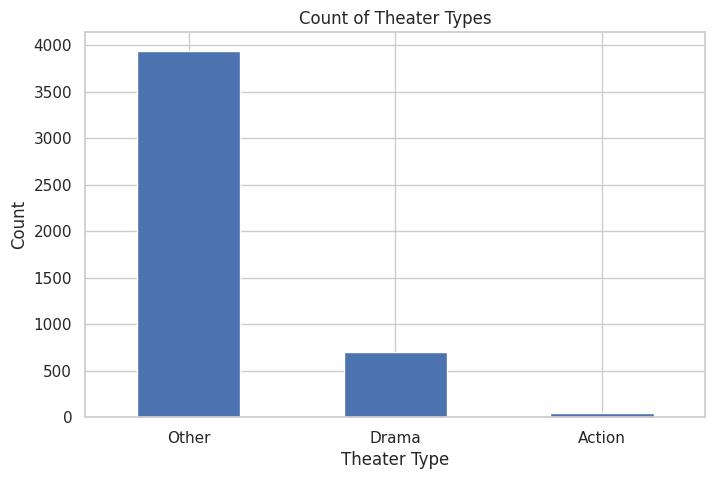

In [47]:
type_counts = cinePOS_theaters['theater_type'].value_counts()

plt.figure(figsize=(8,5))
type_counts.plot(kind='bar')
plt.title("Count of Theater Types")
plt.xlabel("Theater Type")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

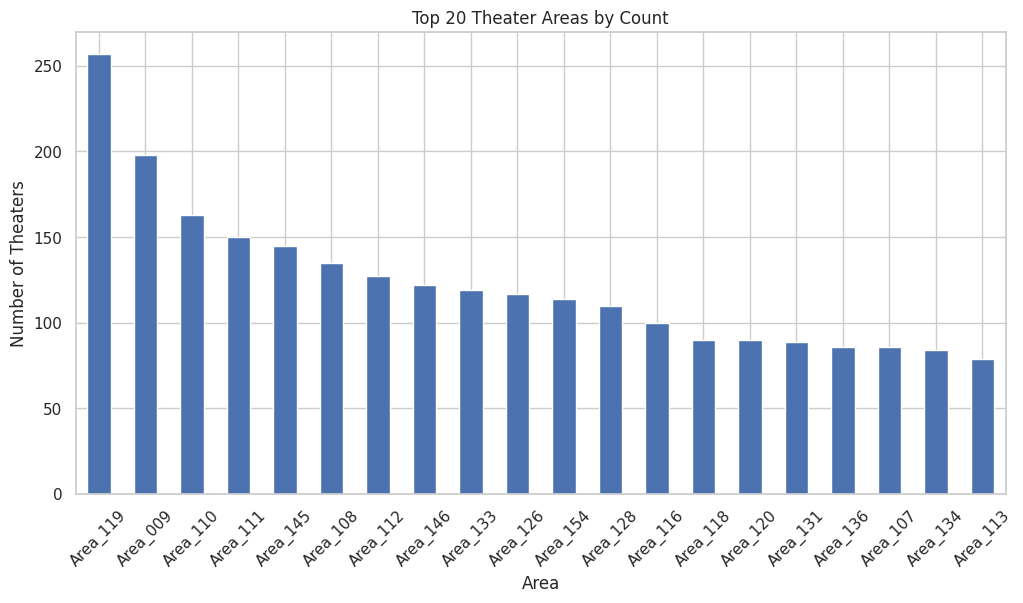

In [48]:
area_counts = cinePOS_theaters['theater_area'].value_counts().head(20)

plt.figure(figsize=(12,6))
area_counts.plot(kind='bar')
plt.title("Top 20 Theater Areas by Count")
plt.xlabel("Area")
plt.ylabel("Number of Theaters")
plt.xticks(rotation=45)
plt.show()

In [49]:
cinePOS_booking.head()

,cine_theater_id,show_datetime,booking_datetime,tickets_sold
0,cinePOS_00001,2023-01-01 11:00:00,2023-01-01 09:00:00,1
1,cinePOS_00002,2023-01-01 13:00:00,2023-01-01 06:00:00,3
2,cinePOS_00003,2023-01-01 16:00:00,2023-01-01 14:00:00,2
3,cinePOS_00004,2023-01-01 17:00:00,2023-01-01 11:00:00,5
4,cinePOS_00005,2023-01-01 17:00:00,2023-01-01 03:00:00,13


In [50]:
explore_dataframe(cinePOS_booking)

Shape: (1641966, 4)

 DataFrame Info:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641966 entries, 0 to 1641965
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   cine_theater_id   1641966 non-null  object
 1   show_datetime     1641966 non-null  object
 2   booking_datetime  1641966 non-null  object
 3   tickets_sold      1641966 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 50.1+ MB

 Unique Values per Column:
----------------------------------------
cine_theater_id: 13161 unique values
show_datetime: 8283 unique values
booking_datetime: 10152 unique values
tickets_sold: 97 unique values

 Missing Values per Column:
----------------------------------------
cine_theater_id     0
show_datetime       0
booking_datetime    0
tickets_sold        0
dtype: int64

 Number of Fully Duplicated Rows: 12541


In [51]:
movie_theater_id_relation.head()

,book_theater_id,cine_theater_id
0,book_00509,cinePOS_01261
1,book_00063,cinePOS_02467
2,book_00054,cinePOS_08923
3,book_00094,cinePOS_02479
4,book_00052,cinePOS_06750


In [52]:
explore_dataframe(movie_theater_id_relation)

Shape: (150, 2)

 DataFrame Info:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   book_theater_id  150 non-null    object
 1   cine_theater_id  150 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB

 Unique Values per Column:
----------------------------------------
book_theater_id: 150 unique values
cine_theater_id: 150 unique values

 Missing Values per Column:
----------------------------------------
book_theater_id    0
cine_theater_id    0
dtype: int64

 Number of Fully Duplicated Rows: 0


# Merging the Dataframes

In [53]:
import pandas as pd

# Assuming all three DataFrames are already loaded and clean:
# booknow_visits, booknow_booking_daily, date_info

# --- Step 1: Merge visits with booking data ---
master_df = booknow_visits.merge(
    booknow_booking_daily,
    on=["book_theater_id", "show_date"],
    how="left"  # keep all visit records even if booking missing
)

# --- Step 2: Merge with date_info ---
master_df = master_df.merge(
    date_info,
    on="show_date",
    how="left"
)

In [54]:
explore_dataframe(master_df)

Shape: (213871, 7)

 DataFrame Info:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213871 entries, 0 to 213870
Data columns (total 7 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   book_theater_id                  213871 non-null  object        
 1   show_date                        213871 non-null  datetime64[ns]
 2   audience_count                   213871 non-null  int64         
 3   total_tickets_booked             21019 non-null   float64       
 4   num_booking_events               21019 non-null   float64       
 5   avg_tickets_booknow_per_booking  21019 non-null   float64       
 6   day_of_week                      213871 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 11.4+ MB

 Unique Values per Column:
----------------------------------------
book_theater_id: 826 unique val

In [55]:
# Sort by theater and date
master_df = master_df.sort_values(['book_theater_id', 'show_date']).reset_index(drop=True)

# Feature Engineering

In [56]:
df = master_df.copy()

In [57]:
# Extract month and week of year from show_date
df['month'] = df['show_date'].dt.month
df['week_of_year'] = df['show_date'].dt.isocalendar().week.astype(int)

# Create is_weekend column
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)

In [58]:
# Create lags & rolling averages per theater
df["lag_1"] = df.groupby("book_theater_id")["audience_count"].shift(1)
df["lag_7"] = df.groupby("book_theater_id")["audience_count"].shift(7)
df["lag_14"] = df.groupby("book_theater_id")["audience_count"].shift(14)
df["rolling_mean_7"] = df.groupby("book_theater_id")["audience_count"].transform(lambda x: x.rolling(7, min_periods=1).mean())
df["rolling_mean_14"] = df.groupby("book_theater_id")["audience_count"].transform(lambda x: x.rolling(14, min_periods=1).mean())

In [59]:
explore_dataframe(df)

Shape: (213871, 15)

 DataFrame Info:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213871 entries, 0 to 213870
Data columns (total 15 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   book_theater_id                  213871 non-null  object        
 1   show_date                        213871 non-null  datetime64[ns]
 2   audience_count                   213871 non-null  int64         
 3   total_tickets_booked             21019 non-null   float64       
 4   num_booking_events               21019 non-null   float64       
 5   avg_tickets_booknow_per_booking  21019 non-null   float64       
 6   day_of_week                      213871 non-null  object        
 7   month                            213871 non-null  int32         
 8   week_of_year                     213871 non-null  int64         
 9   is_weekend                       21

# Post Merge Cleaning & Preprocessing

In [60]:
df["lag_1"] = df["lag_1"].fillna(0)
df["lag_7"] = df["lag_7"].fillna(0)
df["lag_14"] = df["lag_14"].fillna(0)

# Fill missing booking metrics with 0 (means no bookings that day)
df["total_tickets_booked"] = df["total_tickets_booked"].fillna(0)
df["num_booking_events"] = df["num_booking_events"].fillna(0)
df["avg_tickets_booknow_per_booking"] = df["avg_tickets_booknow_per_booking"].fillna(0)

In [61]:
df = df.drop(columns=[
    'total_tickets_booked',
    'num_booking_events',
    'avg_tickets_booknow_per_booking'
])

In [62]:
explore_dataframe(df)

Shape: (213871, 12)

 DataFrame Info:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213871 entries, 0 to 213870
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   book_theater_id  213871 non-null  object        
 1   show_date        213871 non-null  datetime64[ns]
 2   audience_count   213871 non-null  int64         
 3   day_of_week      213871 non-null  object        
 4   month            213871 non-null  int32         
 5   week_of_year     213871 non-null  int64         
 6   is_weekend       213871 non-null  int64         
 7   lag_1            213871 non-null  float64       
 8   lag_7            213871 non-null  float64       
 9   lag_14           213871 non-null  float64       
 10  rolling_mean_7   213871 non-null  float64       
 11  rolling_mean_14  213871 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int32(1), int64

In [63]:
# Check minimum and maximum show_date
min_date = df['show_date'].min()
max_date = df['show_date'].max()


print(f"Minimum show date: {min_date}")
print(f"Maximum show date: {max_date}")

Minimum show date: 2023-01-01 00:00:00
Maximum show date: 2024-02-28 00:00:00


In [64]:
df.head()

,book_theater_id,show_date,audience_count,day_of_week,month,week_of_year,is_weekend,lag_1,lag_7,lag_14,rolling_mean_7,rolling_mean_14
0,book_00001,2023-01-13,50,Friday,1,2,0,0.0,0.0,0.0,50.000000,50.000000
1,book_00001,2023-01-14,64,Saturday,1,2,1,50.0,0.0,0.0,57.000000,57.000000
2,book_00001,2023-01-15,58,Sunday,1,2,1,64.0,0.0,0.0,57.333333,57.333333
3,book_00001,2023-01-16,44,Monday,1,3,0,58.0,0.0,0.0,54.000000,54.000000
4,book_00001,2023-01-18,12,Wednesday,1,3,0,44.0,0.0,0.0,45.600000,45.600000


Only tried scaling the lag and rolling-mean features for linear models.
Tree-based models don’t require scaling.

In [65]:
'''
from sklearn.preprocessing import StandardScaler
# -------------------------------
# 1. Identify numerical columns
# -------------------------------
# scaling only the lag and rolling-mean features
numerical_cols = [
    'lag_1',
    'lag_7',
    'lag_14',
    'rolling_mean_7',
    'rolling_mean_14'
]

print("Numerical columns to scale:", numerical_cols)

# -------------------------------
# 2. Initialize the scaler
# -------------------------------
scaler = StandardScaler()

# -------------------------------
# 3. Fit the scaler on numerical data
#    and transform it
# -------------------------------
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

'''

'\nfrom sklearn.preprocessing import StandardScaler\n# -------------------------------\n# 1. Identify numerical columns\n# -------------------------------\n# scaling only the lag and rolling-mean features\nnumerical_cols = [\n    \'lag_1\',\n    \'lag_7\',\n    \'lag_14\',\n    \'rolling_mean_7\',\n    \'rolling_mean_14\'\n]\n\nprint("Numerical columns to scale:", numerical_cols)\n\n# -------------------------------\n# 2. Initialize the scaler\n# -------------------------------\nscaler = StandardScaler()\n\n# -------------------------------\n# 3. Fit the scaler on numerical data\n#    and transform it\n# -------------------------------\ndf[numerical_cols] = scaler.fit_transform(df[numerical_cols])\n\n'

Scaling had a significant impact on the KNN model because KNN relies entirely on distance calculations to determine the nearest neighbors. When features are on different scales, the larger-magnitude features (like lag values or rolling means) dominate the distance metric, causing the model to ignore smaller-scale features even if they are important. After scaling, all features contribute equally to the distance computation, which changed the neighborhood structure and led the KNN model to select very different sets of “closest” points during prediction. As a result, the performance of KNN shifted notably compared to tree-based models like Random Forest, XGBoost, and LightGBM, which are scale-invariant and therefore unaffected by feature scaling.

In [66]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Label Encode book_theater_id because book_theater_id has 826 unique values (High Cardinality Feature) 
# & Tree-Based Models Can Natively Handle Label Encoded Categories (do not assume ordinal relationships among label-encoded values)

le = LabelEncoder()
df['book_theater_id_encoded'] = le.fit_transform(df['book_theater_id'])
df['day_of_week'] = le.fit_transform(df['day_of_week'])


# Reorder Columns
date_related_cols = ['month', 'week_of_year', 'is_weekend']
lag_rolling_cols = ['lag_1', 'lag_7', 'lag_14', 'rolling_mean_7', 'rolling_mean_14']



ordered_cols = (
    ['book_theater_id', 'book_theater_id_encoded', 'show_date', 'audience_count'] +
    date_related_cols + 
    lag_rolling_cols
)

# Reorder the DataFrame
df = df[ordered_cols]

# Final check
print("Final columns order:")
print(df.columns.tolist())
print("\nShape:", df.shape)

Final columns order:
['book_theater_id', 'book_theater_id_encoded', 'show_date', 'audience_count', 'month', 'week_of_year', 'is_weekend', 'lag_1', 'lag_7', 'lag_14', 'rolling_mean_7', 'rolling_mean_14']

Shape: (213871, 12)


In [67]:
explore_dataframe(df)

Shape: (213871, 12)

 DataFrame Info:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213871 entries, 0 to 213870
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   book_theater_id          213871 non-null  object        
 1   book_theater_id_encoded  213871 non-null  int64         
 2   show_date                213871 non-null  datetime64[ns]
 3   audience_count           213871 non-null  int64         
 4   month                    213871 non-null  int32         
 5   week_of_year             213871 non-null  int64         
 6   is_weekend               213871 non-null  int64         
 7   lag_1                    213871 non-null  float64       
 8   lag_7                    213871 non-null  float64       
 9   lag_14                   213871 non-null  float64       
 10  rolling_mean_7           213871 non-null  float64       
 11 

In [68]:
ref_df=df.copy()

# Model Implementation

In [69]:
import pandas as pd

# Time-based split
train_df = df[df['show_date'] < '2024-01-01']
val_df   = df[df['show_date'] >= '2024-01-01']

print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")

Train shape: (174360, 12)
Validation shape: (39511, 12)


In [70]:
# Define target
target_col = 'audience_count'

# Drop irrelevant columns for features
drop_cols = ['book_theater_id', 'show_date', target_col]

X_train = train_df.drop(columns=drop_cols)
y_train = train_df[target_col]

X_val = val_df.drop(columns=drop_cols)
y_val = val_df[target_col]

print("Feature columns:", X_train.columns.tolist())

Feature columns: ['book_theater_id_encoded', 'month', 'week_of_year', 'is_weekend', 'lag_1', 'lag_7', 'lag_14', 'rolling_mean_7', 'rolling_mean_14']


In [71]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(n_estimators=200, learning_rate=0.1, random_state=42, n_jobs=-1)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    
    # Predictions
    train_preds = model.predict(X_train)
    val_preds   = model.predict(X_val)
    
    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    val_rmse   = np.sqrt(mean_squared_error(y_val, val_preds))
    
    train_r2 = r2_score(y_train, train_preds)
    val_r2   = r2_score(y_val, val_preds)

    results.append((name, train_rmse, val_rmse, train_r2, val_r2))


# Display results
results_df = pd.DataFrame(results,
                          columns=["Model", "Train_RMSE", "Val_RMSE",
                                   "Train_R2", "Val_R2"])
print(results_df.sort_values(by="Val_R2"))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1285
[LightGBM] [Info] Number of data points in the train set: 174360, number of used features: 9
[LightGBM] [Info] Start training from score 42.045607
               Model  Train_RMSE   Val_RMSE  Train_R2    Val_R2
2      KNN Regressor   20.000724  23.094428  0.639264  0.441038
3      Random Forest    8.210323  21.445036  0.939212  0.518029
5            XGBoost   19.499364  21.278810  0.657122  0.525471
6           LightGBM   19.928863  20.802587  0.641851  0.546474
4  Gradient Boosting   20.822386  20.478748  0.609015  0.560484
1   Ridge Regression   21.923991  20.200721  0.566551  0.572337
0  Linear Regression   21.923991  20.200714  0.566551  0.572338


### Inspecting Overfitting and Underfitting

To evaluate whether the trained models are overfitting or underfitting, both training and validation metrics were computed for each model. The table below summarizes the results:

| Model             | Train RMSE | Val RMSE | Train R² | Val R² |
| ----------------- | ---------- | -------- | -------- | ------ |
| KNN Regressor     | 20.0007    | 23.0944  | 0.6393   | 0.4410 |
| Random Forest     | 8.2103     | 21.4450  | 0.9392   | 0.5180 |
| XGBoost           | 19.4994    | 21.2788  | 0.6571   | 0.5255 |
| LightGBM          | 19.9289    | 20.8026  | 0.6419   | 0.5465 |
| Gradient Boosting | 20.8224    | 20.4787  | 0.6090   | 0.5605 |
| Ridge Regression  | 21.9240    | 20.2007  | 0.5666   | 0.5723 |
| Linear Regression | 21.9240    | 20.2007  | 0.5666   | 0.5723 |

#### Random Forest

Random Forest demonstrates clear overfitting. Train_RMSE (8.21) is dramatically lower than Val_RMSE (21.45). Train_R² (0.939) is extremely high, indicating it almost perfectly fits the training data, while Val_R² (0.518) is significantly lower. This large gap suggests the model is memorizing the training set rather than learning general patterns.

#### Linear and Ridge Regression

Both Linear Regression and Ridge Regression show signs of underfitting. They have the lowest Train_R² values (approx 0.567) and the highest Train_RMSE values (approx 21.92). While they have the best generalization (Train_RMSE is close to Val_RMSE, and Val_R² is the highest), their overall performance is still moderate. This indicates that the models are too simple to capture capture the underlying relationships in the dataset.

#### KNN Regressor

KNN exhibits moderate overfitting, with the validation RMSE noticeably higher than the training RMSE. Since KNN makes predictions based on local neighborhoods, it can perform poorly on datasets with high variance or noisy features. 

#### XGBoost

XGBoost shows mild underfitting. Training and validation metrics are close, but both errors remain higher than desirable. This suggests that the current model complexity is not sufficient. 

#### LightGBM

LightGBM performs slightly better than XGBoost and shows a balanced fit. The gap between training and validation error is small, indicating stable generalization. However, since both errors are still relatively high, this model is mildly underfitting and could benefit from moderately increased complexity (e.g., more trees or larger leaf counts).

#### Gradient Boosting

Gradient Boosting provides the best balance among all models. Training and validation metrics are very close, showing neither significant overfitting nor underfitting. It achieves the strongest validation R² (0.560), indicating that it generalizes consistently while capturing important patterns in the data. Increasing the number of estimators or slightly deeper trees may further improve performance.

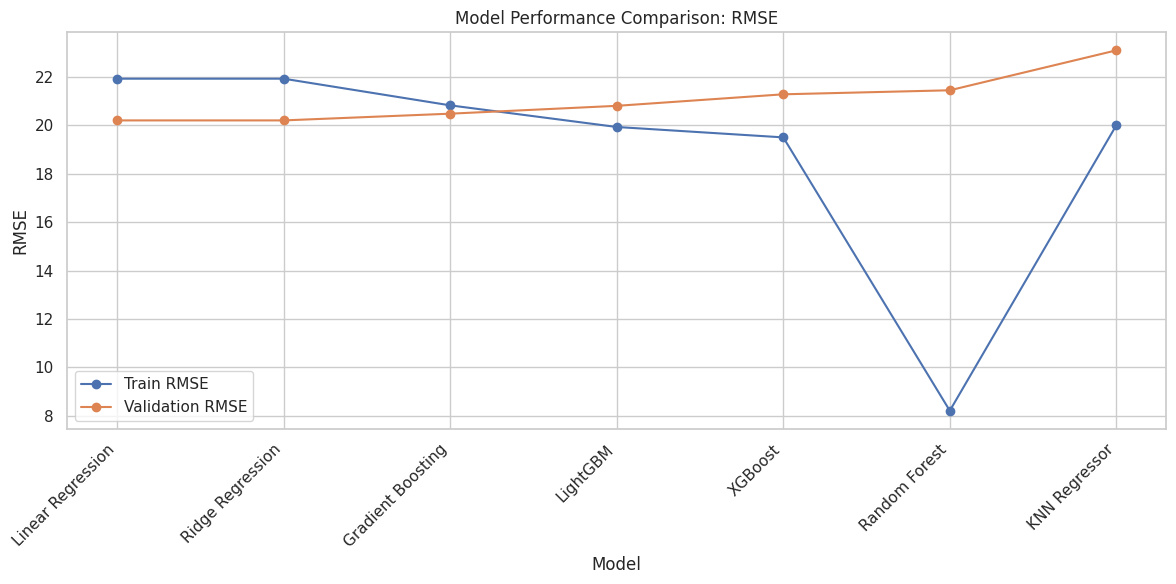

In [72]:
import matplotlib.pyplot as plt

# Sort models for cleaner visual comparison
results_df_sorted = results_df.sort_values(by="Val_RMSE")

# -----------------------------------------------------------
# Plot 1: RMSE Comparison (Train vs Validation)
# -----------------------------------------------------------

plt.figure(figsize=(12, 6))

plt.plot(results_df_sorted["Model"], results_df_sorted["Train_RMSE"],
         marker="o", label="Train RMSE")
plt.plot(results_df_sorted["Model"], results_df_sorted["Val_RMSE"],
         marker="o", label="Validation RMSE")

plt.title("Model Performance Comparison: RMSE")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

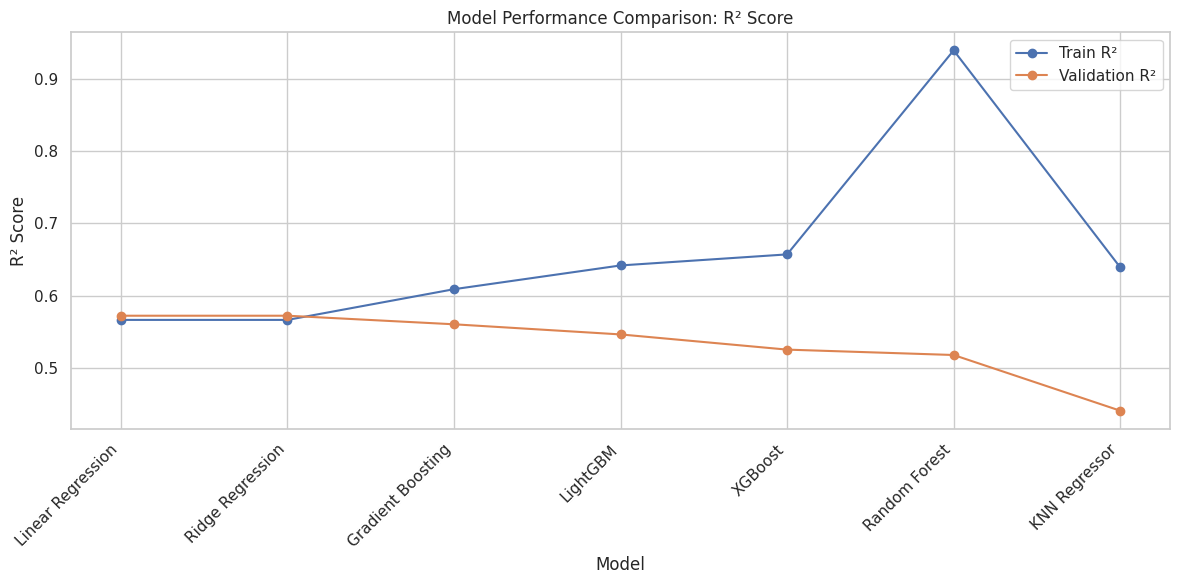

In [73]:
# -----------------------------------------------------------
# Plot 2: R² Score Comparison (Train vs Validation)
# -----------------------------------------------------------

plt.figure(figsize=(12, 6))

plt.plot(results_df_sorted["Model"], results_df_sorted["Train_R2"],
         marker="o", label="Train R²")
plt.plot(results_df_sorted["Model"], results_df_sorted["Val_R2"],
         marker="o", label="Validation R²")

plt.title("Model Performance Comparison: R² Score")
plt.xlabel("Model")
plt.ylabel("R² Score")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Hyper-Parameter Tuning

On the best 2 models:
1. LightGBM
2. Gradient Boosting

In [74]:
'''

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

# -------------------------------
# 1. GRADIENT BOOSTING - TUNING
# -------------------------------

gbr_params = {
    "n_estimators": randint(300, 1200),      
    "learning_rate": uniform(0.01, 0.05),    
    "max_depth": randint(2, 6),              
    "subsample": uniform(0.7, 0.3),         
    "min_samples_split": randint(20, 100),   
    "min_samples_leaf": randint(10, 40)      
}

gbr = GradientBoostingRegressor(random_state=42)

gbr_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=gbr_params,
    n_iter=50,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

gbr_search.fit(X_train, y_train)

print("Best GBR Parameters:", gbr_search.best_params_)
print("Best GBR R2 Score:", gbr_search.best_score_)


# -------------------------------
# 2. LIGHTGBM - TUNING
# -------------------------------

lgb_params = {
    "num_leaves": randint(20, 60),           
    "max_depth": randint(-1, 10),             
    "learning_rate": uniform(0.01, 0.05),     
    "n_estimators": randint(400, 1500),      
    "subsample": uniform(0.7, 0.3),           
    "colsample_bytree": uniform(0.7, 0.3),    
    "min_child_samples": randint(20, 60),     
    "reg_alpha": uniform(0.0, 0.3),           
    "reg_lambda": uniform(0.0, 0.5)           
}

lgb = LGBMRegressor(random_state=42, n_jobs=-1)

lgb_search = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=lgb_params,
    n_iter=60,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

lgb_search.fit(X_train, y_train)

print("Best LGBM Parameters:", lgb_search.best_params_)
print("Best LGBM R2 Score:", lgb_search.best_score_)

'''

'\n\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import uniform, randint\nimport numpy as np\nfrom sklearn.ensemble import GradientBoostingRegressor\nfrom lightgbm import LGBMRegressor\n\n# -------------------------------\n# 1. GRADIENT BOOSTING - TUNING\n# -------------------------------\n\ngbr_params = {\n    "n_estimators": randint(300, 1200),      \n    "learning_rate": uniform(0.01, 0.05),    \n    "max_depth": randint(2, 6),              \n    "subsample": uniform(0.7, 0.3),         \n    "min_samples_split": randint(20, 100),   \n    "min_samples_leaf": randint(10, 40)      \n}\n\ngbr = GradientBoostingRegressor(random_state=42)\n\ngbr_search = RandomizedSearchCV(\n    estimator=gbr,\n    param_distributions=gbr_params,\n    n_iter=50,\n    cv=3,\n    scoring="r2",\n    n_jobs=-1,\n    verbose=2,\n    random_state=42\n)\n\ngbr_search.fit(X_train, y_train)\n\nprint("Best GBR Parameters:", gbr_search.best_params_)\nprint("Best GBR R2 Score:", gbr_searc

### Best Params:

    "Gradient Boosting": GradientBoostingRegressor(
                            n_estimators=600,          # more trees = better learning
                            learning_rate=0.03,        # slower learning, reduces overfit
                            max_depth=3,               # common sweet spot for tabular data
                            min_samples_split=50,
                            min_samples_leaf=20,       # stabilizes leaves (reduces noise)
                            subsample=0.8,             # stochastic boosting → reduces overfitting
                            random_state=42
                        ),


    "LightGBM": LGBMRegressor(
                    n_estimators=1200,          # more boosting rounds
                    learning_rate=0.03,         # slower learning → better generalization
                    num_leaves=31,              # control model complexity
                    max_depth= -1,              # let LGBM decide based on num_leaves
                    min_child_samples=40,       # reduce noise fitting
                    subsample=0.8,              # stochastic gradient boosting
                    colsample_bytree=0.8,       # feature sampling
                    reg_alpha=0.1,              # L1 regularization
                    reg_lambda=0.3,             # L2 regularization
                    random_state=42,
                    n_jobs=-1
                ),

### Model Performance Comparison

This report compares the performance of four baseline regression models—**Random Forest**, **Gradient Boosting**, **XGBoost**, and **LightGBM**—along with **hypertuned versions** of Gradient Boosting and LightGBM.
Performance metrics used:

* **RMSE (Root Mean Squared Error)** — lower is better
* **R² Score** — higher is better

---

### Baseline Model Performance

| Model             | RMSE      | R² Score   |
| ----------------- | --------- | ---------- |
| Random Forest     | 21.45     | 0.5180     |
| XGBoost           | 21.28     | 0.5255     |
| LightGBM          | 20.80     | 0.5465     |
| Gradient Boosting | **20.48** | **0.5605** |

### Insights

* **Gradient Boosting** is the strongest among baseline models with the best RMSE and R².
* **LightGBM** follows closely, showing strong generalization without tuning.
* Random Forest and XGBoost show comparatively weaker performance on this dataset.

---

### Hypertuned Models

### 1. **Hypertuned Gradient Boosting**

**Parameters tuned:**

* Increased `n_estimators` (600)
* Reduced `learning_rate` (0.03)
* Regularized with `min_samples_split`, `min_samples_leaf`
* Used `subsample=0.8` to reduce overfitting

| Model                     | RMSE      | R² Score   |
| ------------------------- | --------- | ---------- |
| Gradient Boosting (Tuned) | **20.30** | **0.5683** |

####  Insight

This version **outperforms all models**, including the baseline Gradient Boosting.
The slower learning rate + more trees + regularization significantly boosted generalization.

---

### 2. **Hypertuned LightGBM**

**Parameters tuned:**

* Increased `n_estimators` (1200)
* Reduced `learning_rate` (0.03)
* Added regularization (`reg_alpha`, `reg_lambda`)
* Used subsampling + feature sampling

| Model            | RMSE  | R² Score |
| ---------------- | ----- | -------- |
| LightGBM (Tuned) | 20.76 | 0.5485   |

####  Insight

Surprisingly, tuning **did not significantly improve** LightGBM performance.
The tuned model performed **slightly worse** than the baseline (RMSE ↑, R² ↓), suggesting that:

* The default LGBM hyperparameters were already close to optimal
* Added regularization + slowed learning may have led to **underfitting**

---

### Final Ranking (by R² Score)

1. **Gradient Boosting (Tuned)** — *Best performing model*
2. Gradient Boosting (Baseline)
3. LightGBM (Baseline)
4. LightGBM (Tuned)
5. XGBoost
6. Random Forest

---

### Overall Conclusions

* **Gradient Boosting emerges as the strongest model** on this dataset, both baseline and tuned.
* **LightGBM is powerful out-of-the-box**, but the chosen tuning configuration reduced performance—likely due to over-regularization or a mismatch between learning rate and number of estimators.
* **Tree-based boosting methods outperform Random Forest** and even XGBoost in this specific setup.

In [75]:
from sklearn.ensemble import GradientBoostingRegressor

# Prepare full data
target_col = 'audience_count'
drop_cols = ['book_theater_id', 'show_date', target_col]

X_full = df.drop(columns=drop_cols)
y_full = df[target_col]

# Fit best model on full data
final_model = GradientBoostingRegressor(
                            n_estimators=600,          # more trees = better learning
                            learning_rate=0.03,        # slower learning, reduces overfit
                            max_depth=3,               # common sweet spot for tabular data
                            min_samples_split=50,
                            min_samples_leaf=20,       # stabilizes leaves (reduces noise)
                            subsample=0.8,             # stochastic boosting → reduces overfitting
                            random_state=42
              )


final_model.fit(X_full, y_full)

print("Final GradientBoostingRegressor trained on full dataset.")

Final GradientBoostingRegressor trained on full dataset.


# Submission

In [76]:
sample_sub = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv')
sample_sub.head()

,ID,audience_count
0,book_00001_2024-03-01,0
1,book_00001_2024-03-02,0
2,book_00001_2024-03-03,0
3,book_00001_2024-03-04,0
4,book_00001_2024-03-06,0


In [77]:
sample_sub.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38062 entries, 0 to 38061
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              38062 non-null  object
 1   audience_count  38062 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 594.8+ KB


In [78]:
# ---------------- Step 1: Start from sample submission ----------------
sample_sub[['book_theater_id','show_date']] = sample_sub['ID'].str.rsplit('_', n=1, expand=True)
sample_sub['show_date'] = pd.to_datetime(sample_sub['show_date'])

In [79]:
sample_sub.head()


,ID,audience_count,book_theater_id,show_date
0,book_00001_2024-03-01,0,book_00001,2024-03-01
1,book_00001_2024-03-02,0,book_00001,2024-03-02
2,book_00001_2024-03-03,0,book_00001,2024-03-03
3,book_00001_2024-03-04,0,book_00001,2024-03-04
4,book_00001_2024-03-06,0,book_00001,2024-03-06


In [80]:
submission=sample_sub.copy()
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38062 entries, 0 to 38061
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               38062 non-null  object        
 1   audience_count   38062 non-null  int64         
 2   book_theater_id  38062 non-null  object        
 3   show_date        38062 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.2+ MB


In [81]:
# Left join submission with date_info on show_date
submission= submission.merge(
    date_info,
    on='show_date',
    how='left'
)

# Verify result
print(submission.info())
print(submission.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38062 entries, 0 to 38061
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               38062 non-null  object        
 1   audience_count   38062 non-null  int64         
 2   book_theater_id  38062 non-null  object        
 3   show_date        38062 non-null  datetime64[ns]
 4   day_of_week      38062 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.5+ MB
None
                      ID  audience_count book_theater_id  show_date  \
0  book_00001_2024-03-01               0      book_00001 2024-03-01   
1  book_00001_2024-03-02               0      book_00001 2024-03-02   
2  book_00001_2024-03-03               0      book_00001 2024-03-03   
3  book_00001_2024-03-04               0      book_00001 2024-03-04   
4  book_00001_2024-03-06               0      book_00001 2024-03-06   

  day_of_week  
0   

In [82]:
# Extract month and week of year from show_date
submission['month'] = submission['show_date'].dt.month
submission['week_of_year'] = submission['show_date'].dt.isocalendar().week.astype(int)

# Create is_weekend column
submission['is_weekend'] = submission['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)

In [83]:
import pandas as pd
import numpy as np

def create_submission_lags_extended(submission_df, history_df, 
                                    target='audience_count', 
                                    group_col='book_theater_id',
                                    lags=[1,7,14], 
                                    rolling_windows=[7,14]):
    """
    Create lag, rolling mean, rolling median, rolling std, and EWM features for submission
    using only history_df.
    Handles new theaters using global median fallback.
    """
    
    submission_df = submission_df.sort_values([group_col, 'show_date']).copy()
    
    # Prepare theater-wise history from history_df
    theater_history = {
        theater: df_group.sort_values('show_date')[target].tolist()
        for theater, df_group in history_df.groupby(group_col)
    }
    
    # Initialize lag and rolling columns
    for lag in lags:
        submission_df[f'lag_{lag}'] = np.nan
    for window in rolling_windows:
        submission_df[f'rolling_mean_{window}'] = np.nan

    # Global median fallback
    global_median = history_df[target].median()
    
    # Compute features
    for idx, row in submission_df.iterrows():
        theater = row[group_col]
        past_values = theater_history.get(theater, [global_median]*max(lags+rolling_windows))
        
        # Lag features
        for lag in lags:
            submission_df.at[idx, f'lag_{lag}'] = past_values[-lag] if len(past_values) >= lag else global_median
        
        # Rolling / EWM features
        for window in rolling_windows:
            window_values = past_values[-window:] if len(past_values) >= window else past_values
            submission_df.at[idx, f'rolling_mean_{window}'] = np.mean(window_values)
    
    return submission_df


submission_lag = create_submission_lags_extended(
    submission_df=submission,
    history_df=ref_df,
    target='audience_count',
    group_col='book_theater_id',
    lags=[1,7,14],
    rolling_windows=[7,14]
)

In [84]:
explore_dataframe(submission_lag)

Shape: (38062, 13)

 DataFrame Info:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38062 entries, 0 to 38061
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               38062 non-null  object        
 1   audience_count   38062 non-null  int64         
 2   book_theater_id  38062 non-null  object        
 3   show_date        38062 non-null  datetime64[ns]
 4   day_of_week      38062 non-null  object        
 5   month            38062 non-null  int32         
 6   week_of_year     38062 non-null  int64         
 7   is_weekend       38062 non-null  int64         
 8   lag_1            38062 non-null  float64       
 9   lag_7            38062 non-null  float64       
 10  lag_14           38062 non-null  float64       
 11  rolling_mean_7   38062 non-null  float64       
 12  rolling_mean_14  38062 non-null  float64       
dtypes: datetime64

In [85]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Label Encode book_theater_id
le = LabelEncoder()
submission_lag['book_theater_id_encoded'] = le.fit_transform(submission_lag['book_theater_id'])
submission_lag['day_of_week'] = le.fit_transform(submission_lag['day_of_week'])


# Reorder Columns
date_related_cols = ['month', 'week_of_year', 'is_weekend']
lag_rolling_cols = ['lag_1', 'lag_7', 'lag_14', 'rolling_mean_7', 'rolling_mean_14']



ordered_cols = (
    ['ID', 'book_theater_id', 'book_theater_id_encoded', 'show_date', 'audience_count'] +
    date_related_cols + 
    lag_rolling_cols
)
# Reorder the DataFrame
submission_final = submission_lag[ordered_cols]

# Final check
print("Final columns order:")
print(submission_final.columns.tolist())
print("\nShape:", submission_final.shape)

Final columns order:
['ID', 'book_theater_id', 'book_theater_id_encoded', 'show_date', 'audience_count', 'month', 'week_of_year', 'is_weekend', 'lag_1', 'lag_7', 'lag_14', 'rolling_mean_7', 'rolling_mean_14']

Shape: (38062, 13)


In [86]:
explore_dataframe(submission_final)

Shape: (38062, 13)

 DataFrame Info:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38062 entries, 0 to 38061
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID                       38062 non-null  object        
 1   book_theater_id          38062 non-null  object        
 2   book_theater_id_encoded  38062 non-null  int64         
 3   show_date                38062 non-null  datetime64[ns]
 4   audience_count           38062 non-null  int64         
 5   month                    38062 non-null  int32         
 6   week_of_year             38062 non-null  int64         
 7   is_weekend               38062 non-null  int64         
 8   lag_1                    38062 non-null  float64       
 9   lag_7                    38062 non-null  float64       
 10  lag_14                   38062 non-null  float64       
 11  rolling_mean_7 

In [87]:
# Drop non-feature columns
X_submit = submission_final.drop(columns=['ID', 'book_theater_id', 'show_date', 'audience_count'])

# Generate predictions
submission_final['audience_count'] = final_model.predict(X_submit)

/tmp/ipykernel_13/3414811228.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_final['audience_count'] = final_model.predict(X_submit)


In [88]:
# See sample predictions
print(submission_final[['book_theater_id', 'show_date', 'audience_count']].head())

  book_theater_id  show_date  audience_count
0      book_00001 2024-03-01       33.503738
1      book_00001 2024-03-02       45.934445
2      book_00001 2024-03-03       45.934445
3      book_00001 2024-03-04       33.503738
4      book_00001 2024-03-06       33.503738


In [89]:
# Save to CSV if needed
submission_final[['ID', 'audience_count']].to_csv(
    'submission_file.csv', index=False
)
print("submission_file.csv saved successfully!")

submission_file.csv saved successfully!


# MILESTONES

In [90]:
#JUST FOR NAME REFERENCE EASE :)

# MILESTONE 1 

'''

movie_theater_id_relation_original = movie_theater_id_relation.copy()
date_info_original = date_info.copy()
sample_submission_original = sample_submission.copy()
booknow_theaters_original = booknow_theaters.copy()
cinePOS_booking_original = cinePOS_booking.copy()
cinePOS_theaters_original = cinePOS_theaters.copy()
booknow_visits_original = booknow_visits.copy()
booknow_booking_original = booknow_booking.copy()



#Q1: What is the shape of the dataset named booknow_booking?
#Note: If the dataset has x rows & y columns, enter your answer as (x,y)
booknow_booking_original.shape

#ANSWER: (68336, 4)


#Q2:How many columns are of type Object in the dataset named cinePOS_theaters?
cinePOS_theaters_original.info()

#ANSWER: 3

#Q3. Which of the following theater types is the most frequent in the dataset named booknow_theaters?
booknow_theaters_original.info()

count_freq=booknow_theaters_original['theater_type'].value_counts()
count_freq


#ANSWER: Other 

#Q4: How many distinct theaters are present in the dataset named cinePOS_booking?
cinePOS_booking_original.info()

distinct_theaters = cinePOS_booking_original['cine_theater_id'].nunique()
distinct_theaters

#Q5: Combine the datasets booknow_booking and booknow_theaters. 
#What is the shape of this dataset? 
#Hint: Read about inner join for dataframes and its implementation using Pandas 
#Note: If the dataset has x rows & y columns, enter your answer as (x,y)
print(booknow_booking_original.info())
print("---------------------------------")
print("---------------------------------")
print("---------------------------------")
print(booknow_theaters_original.info())

combined = pd.merge(booknow_booking, booknow_theaters, on="book_theater_id", how="inner")
print(combined.shape) : (34587, 10)
combined.info()

#Q6: Based on the combined dataset obtained in the previous question,
#how many distinct areas are the theaters located in?
distinct_areas = combined['theater_area'].nunique()
print(distinct_areas): 50

#Q7: Combine the datasets movie_theater_id_relation, cinePOS_booking and cinePOS_theaters. 
#Enter the column names containing missing values as comma seperated values
#Hint: Read about inner join for dataframes and its implementation using Pandas

movie_theater_id_relation_original.info()
print('-----------------------------------------')
print('-----------------------------------------')
cinePOS_booking_original.info()
print('-----------------------------------------')
print('-----------------------------------------')
cinePOS_theaters_original.info()


combined2 = movie_theater_id_relation_original.merge(cinePOS_booking_original, on="cine_theater_id", how="inner") \
                                     .merge(cinePOS_theaters_original, on="cine_theater_id", how="inner")

missing_cols = combined2.columns[combined2.isnull().any()].tolist()
print(",".join(missing_cols)): latitude,longitude

#Q8: Enter the date range spanned in the dataset named booknow_booking. 
#Hint: Find the earliest and latest date for which data is available in this dataset. 
#Note: Enter the answer as "dd-mm-yyyy to dd-mm-yyyy". 
booknow_booking_original.info()

booknow_booking_original['show_datetime'] = pd.to_datetime(booknow_booking_original['show_datetime'])

start_date = booknow_booking_original['show_datetime'].min().strftime("%d-%m-%Y")
end_date   = booknow_booking_original['show_datetime'].max().strftime("%d-%m-%Y")

print(f"{start_date} to {end_date}")

# ANSWER: 01-01-2023 to 28-02-2024


#Q9: Enter the date range spanned in the test dataset (sample_submission).
#Hint: Find the earliest and latest date for which data is available in this dataset. 
#Note: Enter the answer as "dd-mm-yyyy to dd-mm-yyyy". 

# ANSWER: 01-03-2024 to 22-04-2024

'''

'\n\nmovie_theater_id_relation_original = movie_theater_id_relation.copy()\ndate_info_original = date_info.copy()\nsample_submission_original = sample_submission.copy()\nbooknow_theaters_original = booknow_theaters.copy()\ncinePOS_booking_original = cinePOS_booking.copy()\ncinePOS_theaters_original = cinePOS_theaters.copy()\nbooknow_visits_original = booknow_visits.copy()\nbooknow_booking_original = booknow_booking.copy()\n\n\n\n#Q1: What is the shape of the dataset named booknow_booking?\n#Note: If the dataset has x rows & y columns, enter your answer as (x,y)\nbooknow_booking_original.shape\n\n#ANSWER: (68336, 4)\n\n\n#Q2:How many columns are of type Object in the dataset named cinePOS_theaters?\ncinePOS_theaters_original.info()\n\n#ANSWER: 3\n\n#Q3. Which of the following theater types is the most frequent in the dataset named booknow_theaters?\nbooknow_theaters_original.info()\n\ncount_freq=booknow_theaters_original[\'theater_type\'].value_counts()\ncount_freq\n\n\n#ANSWER: Other \

In [91]:
# MILESTONE 2

'''

import pandas as pd
import numpy as np

# ----------------------------------------------------------
# 1. Total bookings made on the same calendar day as show_date
# ----------------------------------------------------------
# Convert to date only (drop time)
booknow_booking['booking_date_only'] = pd.to_datetime(booknow_booking['booking_date']).dt.date
booknow_booking['show_date_only'] = pd.to_datetime(booknow_booking['show_date']).dt.date

same_day_bookings = (booknow_booking['booking_date_only'] ==
                     booknow_booking['show_date_only']).sum()

print("Same-day bookings:", same_day_bookings)   # 20433
# ----------------------------------------------------------


# ----------------------------------------------------------
# 2. Number of unique calendar months in show_date of date_info.csv
# ----------------------------------------------------------
date_info['show_date'] = pd.to_datetime(date_info['show_date'])
unique_months = date_info['show_date'].dt.to_period('M').nunique()

print("Unique calendar months:", unique_months)   # 18
# ----------------------------------------------------------


# ----------------------------------------------------------
# 3. Percentage of bookings made on Sunday
# ----------------------------------------------------------
booknow_booking['booking_date'] = pd.to_datetime(booknow_booking['booking_date'])
pct_sunday = (booknow_booking['booking_date'].dt.dayofweek == 6).mean() * 100

print("Percentage Sunday bookings:", pct_sunday)   # 13.32
# ----------------------------------------------------------


# ----------------------------------------------------------
# 4. Mean latitude of theaters with theater_type == "Drama"
# ----------------------------------------------------------
drama_lat_mean = booknow_theaters.loc[
    booknow_theaters['theater_type'] == 'Drama', 'latitude'
].mean()

print("Imputation value (Drama latitude mean):", drama_lat_mean)
# 23.00090271008748
# ----------------------------------------------------------


# ----------------------------------------------------------
# 5. Range (max - min) of latitude in booknow_theaters
# ----------------------------------------------------------
lat_range = round(
    booknow_theaters['latitude'].max() - booknow_theaters['latitude'].min(),
    4
)
print("Latitude range:", lat_range)  # 4.3235
# ----------------------------------------------------------


# ----------------------------------------------------------
# 6. 95th percentile of tickets_sold in cinePOS_booking
# ----------------------------------------------------------
p95_tickets = cinePOS_booking['tickets_sold'].quantile(0.95)

print("95th percentile (tickets_sold):", p95_tickets)  # 14.0
# ----------------------------------------------------------


# ----------------------------------------------------------
# 7. OneHot Encoding on all categorical columns of cinePOS_theaters
# ----------------------------------------------------------
# Identify categorical columns automatically
cat_cols = cinePOS_theaters.select_dtypes(include=['object', 'category']).columns

cinePOS_theaters_encoded = pd.get_dummies(cinePOS_theaters, columns=cat_cols)

print("Shape after OneHot encoding:", cinePOS_theaters_encoded.shape)
# (4690, 4814)
# ----------------------------------------------------------

'''

'\n\nimport pandas as pd\nimport numpy as np\n\n# ----------------------------------------------------------\n# 1. Total bookings made on the same calendar day as show_date\n# ----------------------------------------------------------\n# Convert to date only (drop time)\nbooknow_booking[\'booking_date_only\'] = pd.to_datetime(booknow_booking[\'booking_date\']).dt.date\nbooknow_booking[\'show_date_only\'] = pd.to_datetime(booknow_booking[\'show_date\']).dt.date\n\nsame_day_bookings = (booknow_booking[\'booking_date_only\'] ==\n                     booknow_booking[\'show_date_only\']).sum()\n\nprint("Same-day bookings:", same_day_bookings)   # 20433\n# ----------------------------------------------------------\n\n\n# ----------------------------------------------------------\n# 2. Number of unique calendar months in show_date of date_info.csv\n# ----------------------------------------------------------\ndate_info[\'show_date\'] = pd.to_datetime(date_info[\'show_date\'])\nunique_months =